# Time series forecast based on Google Analytics test acount custom report

In [1]:
import pandas as pd
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read Google Analytics custom CSV-report

df = pd.read_csv('report.csv', skiprows=7, decimal=',', names = ['date','users','new_users',
                                                                'sessions_per_user','avg_session_duration',
                                                                'bounce_rate','pages_per_session',
                                                                'goals','profit'])
df = df.dropna()
df.head()

,date,users,new_users,sessions_per_user,avg_session_duration,bounce_rate,pages_per_session,goals,profit
0,20211203,8 390,7 734,1.07,00:02:45,"42,11 %",4.76,1 517,"21 555,66 $"
1,20221207,8 161,6 641,1.11,00:04:28,"40,34 %",5.40,3 617,"35 423,39 $"
2,20220406,6 529,5 768,1.09,00:03:02,"38,07 %",4.90,1 837,"10 418,93 $"
3,20220927,6 202,4 051,1.25,00:07:50,"26,60 %",11.95,4 284,"15 844,59 $"
4,20221128,5 176,2 929,1.15,00:04:55,"31,95 %",7.83,2 311,"23 887,74 $"


In [3]:
# Check DataFrame size

df.shape

(1268, 9)

In [4]:
# Data typew overview

df.dtypes

date                     object
users                    object
new_users                object
sessions_per_user       float64
avg_session_duration     object
bounce_rate              object
pages_per_session       float64
goals                    object
profit                   object
dtype: object

In [5]:
# Data types transformation

df['users'] = df['users'].apply(lambda x: x.replace('\xa0','')).astype('int')
df['new_users'] = df['new_users'].apply(lambda x: x.replace('\xa0','')).astype('int')
df['bounce_rate'] = df['bounce_rate'].apply(lambda x: x.replace('%','').replace('\xa0','').replace(',','.')).astype('float')
df['goals'] = df['goals'].apply(lambda x: x.replace('\xa0','')).astype('int')
df['profit'] = df['profit'].apply(lambda x: x.replace('\xa0','').replace('$','').replace(',','.')).astype('float')

In [6]:
# Convert timedelta to seconds

def convert_to_seconds(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    time_delta = datetime.timedelta(hours=hours, minutes=minutes, seconds=seconds)
    return time_delta.total_seconds()

df['avg_session_duration'] = df['avg_session_duration'].apply(convert_to_seconds).astype('int')

In [7]:
# Format date to datetime with required pattern

df['date'] = pd.to_datetime(df['date'], format="%Y%m%d")

In [8]:
# Set dates column as index

df.set_index('date', inplace=True)

In [9]:
# Data types after trasform

df.dtypes

users                     int64
new_users                 int64
sessions_per_user       float64
avg_session_duration      int64
bounce_rate             float64
pages_per_session       float64
goals                     int64
profit                  float64
dtype: object

In [10]:
# Data split

df_validation = df['2022':].sort_index()
df = df[:'2021'].sort_index()

In [11]:
df.head()

,users,new_users,sessions_per_user,avg_session_duration,bounce_rate,pages_per_session,goals,profit
date,,,,,,,,
2020-01-01,1210,1040,1.09,166,51.29,4.49,162,560.25
2020-01-02,1709,1320,1.10,152,45.03,4.29,243,38.00
2020-01-03,1469,1164,1.09,162,44.53,4.42,228,125.60
2020-01-04,1149,973,1.11,157,49.02,4.08,150,40.00
2020-01-05,1106,930,1.10,152,47.98,3.88,125,280.25


In [12]:
# Descriptive statistics

df.describe().round(2)

,users,new_users,sessions_per_user,avg_session_duration,bounce_rate,pages_per_session,goals,profit
count,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00
mean,2047.47,1619.39,1.11,184.58,47.78,4.78,404.66,2877.86
std,635.23,490.13,0.02,27.42,4.63,0.69,227.65,4417.72
min,932.00,760.00,1.06,113.00,30.27,3.37,107.00,0.00
25%,1545.00,1257.00,1.10,165.00,44.57,4.25,239.50,114.80
50%,2037.00,1598.00,1.11,182.00,47.76,4.71,331.00,469.20
75%,2422.00,1868.50,1.13,203.00,51.00,5.20,540.50,4722.79
max,8390.00,7734.00,1.21,314.00,60.84,8.34,1517.00,29633.10


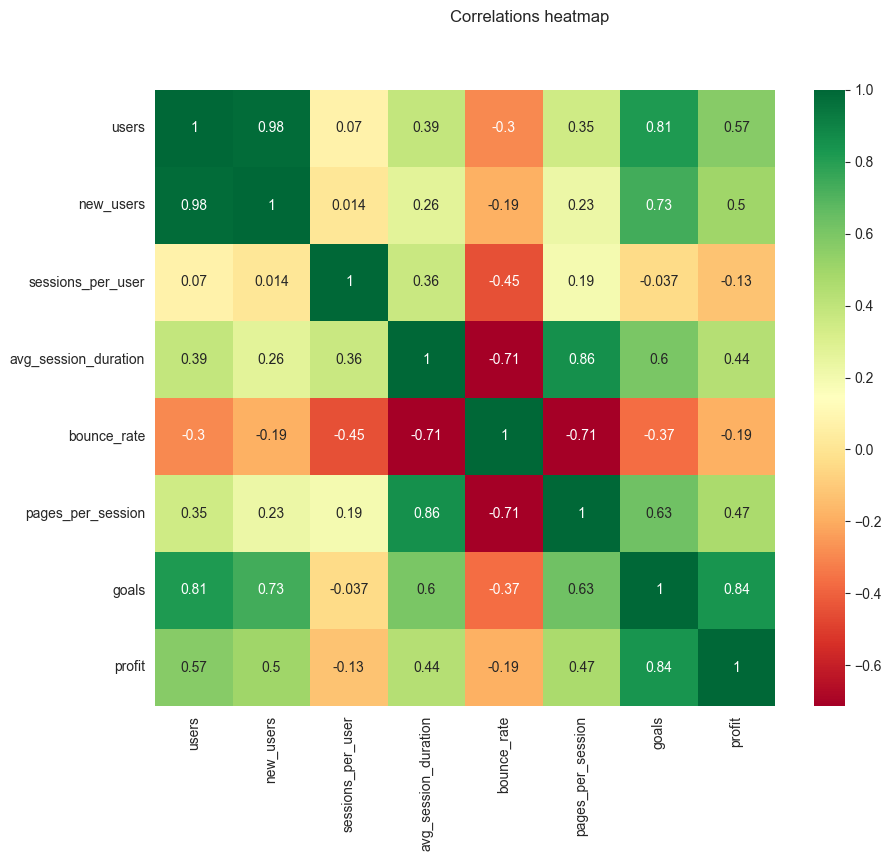

In [13]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='RdYlGn', annot=True)
plt.suptitle('Correlations heatmap')
plt.show()

<Figure size 1100x800 with 0 Axes>

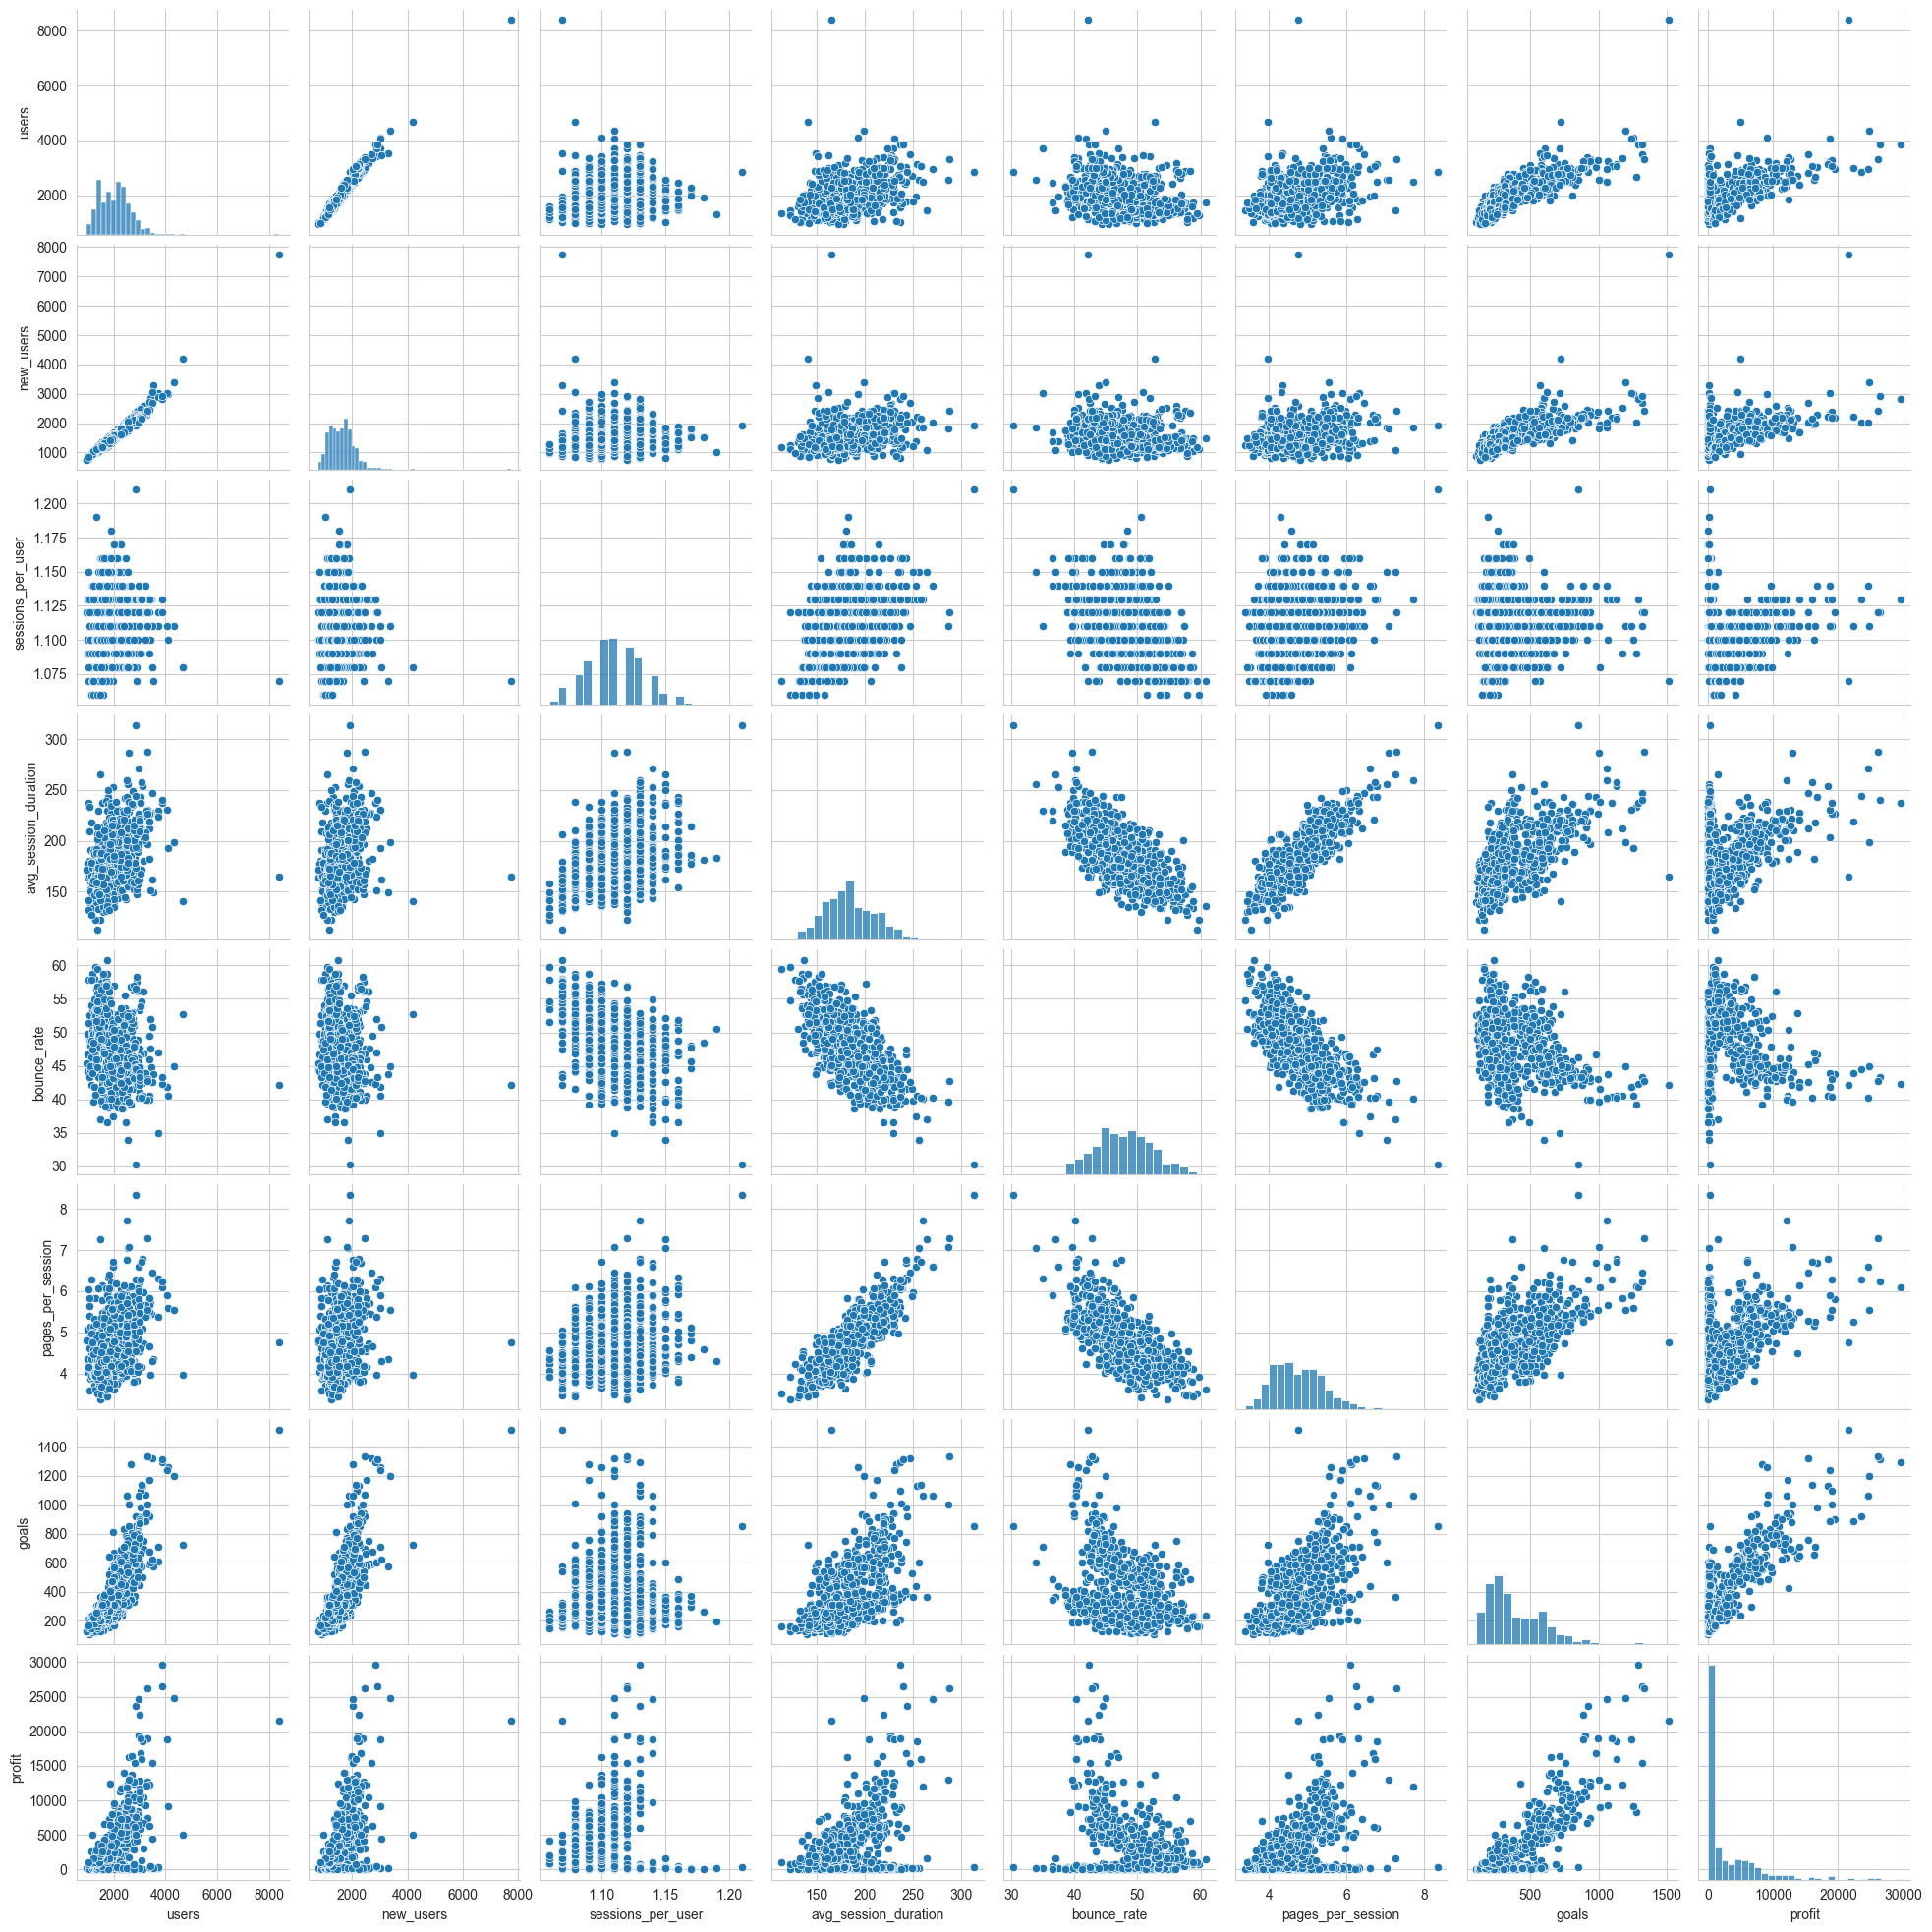

In [14]:
plt.figure(figsize=(11,8))
sns.pairplot(data=df)
plt.show()

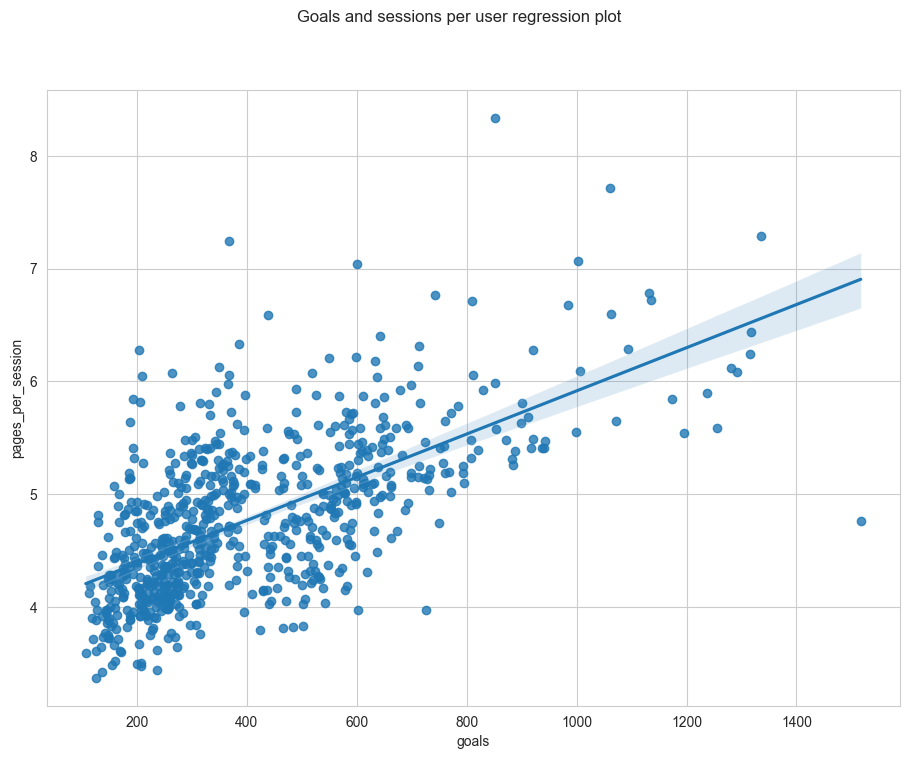

In [15]:
plt.figure(figsize=(11,8))
sns.regplot(data=df, x='goals', y='pages_per_session')
plt.suptitle('Goals and sessions per user regression plot')
plt.show()

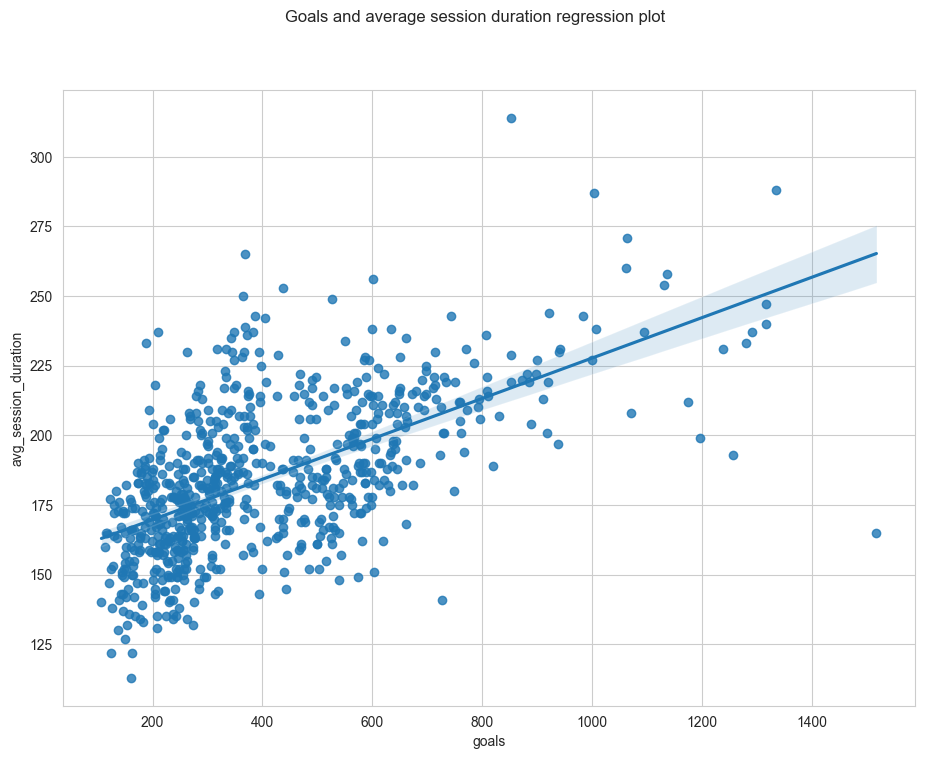

In [16]:
plt.figure(figsize=(11,8))
sns.regplot(data=df, x='goals', y='avg_session_duration')
plt.suptitle('Goals and average session duration regression plot')
plt.show()

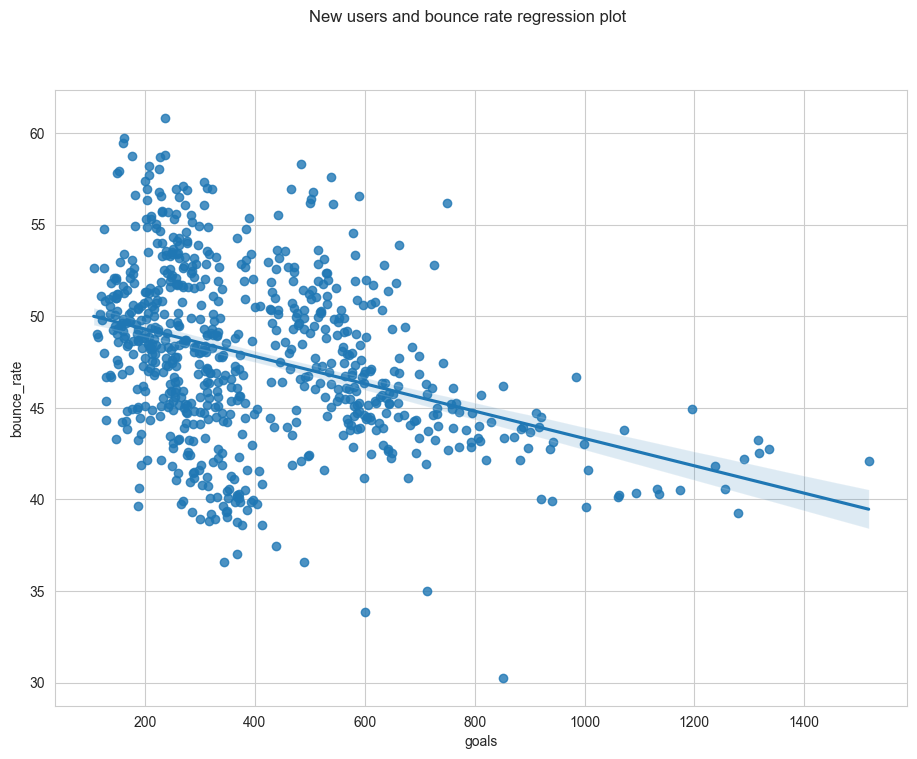

In [17]:
plt.figure(figsize=(11,8))
sns.regplot(data=df, x='goals', y='bounce_rate')
plt.suptitle('New users and bounce rate regression plot')
plt.show()

In [18]:
# Check time series stationarity using ADF test

cols = df.columns
non_stationary = []
stationary = []

for c in cols:
    adf_test = adfuller(df[c])
    p_value = adf_test[1]
    print(f'P-value for {c} time series:{p_value.round(3)}')
    print('---------------------------------------')
    if p_value>0.05:
        non_stationary.append(c)
    else:
        stationary.append(c)
        
non_stationary, stationary

P-value for users time series:0.006
---------------------------------------
P-value for new_users time series:0.003
---------------------------------------
P-value for sessions_per_user time series:0.109
---------------------------------------
P-value for avg_session_duration time series:0.018
---------------------------------------
P-value for bounce_rate time series:0.184
---------------------------------------
P-value for pages_per_session time series:0.097
---------------------------------------
P-value for goals time series:0.174
---------------------------------------
P-value for profit time series:0.38
---------------------------------------


(['sessions_per_user', 'bounce_rate', 'pages_per_session', 'goals', 'profit'],
 ['users', 'new_users', 'avg_session_duration'])

In [19]:
# Function for time series prediction and plotting

def make_prediction(feature_name):
    
    data = df[feature_name]
    data_monthly = data.resample('M').mean()
    model = sm.tsa.SARIMAX(data_monthly, order=(1, 1, 1),
                           seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=18)
    forecasted_values = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()

    
    plt.figure(figsize=(14, 6))
    sns.lineplot(df[feature_name], 
                 label='Historical data',
                 color='steelblue')
    sns.lineplot(x=df.index, 
                 y=df[feature_name].rolling(window=30).mean(), 
                 color='orange', 
                 label='Trendline')
    sns.lineplot(forecasted_values, label='Forecast',
                 color='red')
    plt.fill_between(confidence_intervals.index, 
                     confidence_intervals.iloc[:, 0], 
                     confidence_intervals.iloc[:, 1], 
                     color='black', alpha=0.3, 
                     label='Confidence interval')
    sns.lineplot(x = df_validation.index, 
                 y = df_validation[feature_name].rolling(window=30).mean(),
                 color='green',
                 label='Validation data')
    plt.xlabel('Date')
    plt.ylabel(feature_name.title().replace('_',' '))
    plt.suptitle('Time series forecast and visual evaluation')
    plt.legend()
    plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05519D+00    |proj g|=  8.84259D-01

At iterate    5    f=  3.15778D+00    |proj g|=  2.47367D-03

At iterate   10    f=  3.15737D+00    |proj g|=  1.19420D-02

At iterate   15    f=  3.15623D+00    |proj g|=  4.13492D-03

At iterate   20    f=  3.15610D+00    |proj g|=  2.77549D-04

At iterate   25    f=  3.15599D+00    |proj g|=  3.50568D-03

At iterate   30    f=  3.15590D+00    |proj g|=  1.32775D-03

At iterate   35    f=  3.15354D+00    |proj g|=  1.90519D-02

At iterate   40    f=  3.15258D+00    |proj g|=  6.25460D-03


 This problem is unconstrained.



At iterate   45    f=  3.15197D+00    |proj g|=  3.29081D-03

At iterate   50    f=  3.15173D+00    |proj g|=  3.76036D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   3.760D-03   3.152D+00
  F =   3.1517313706369392     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


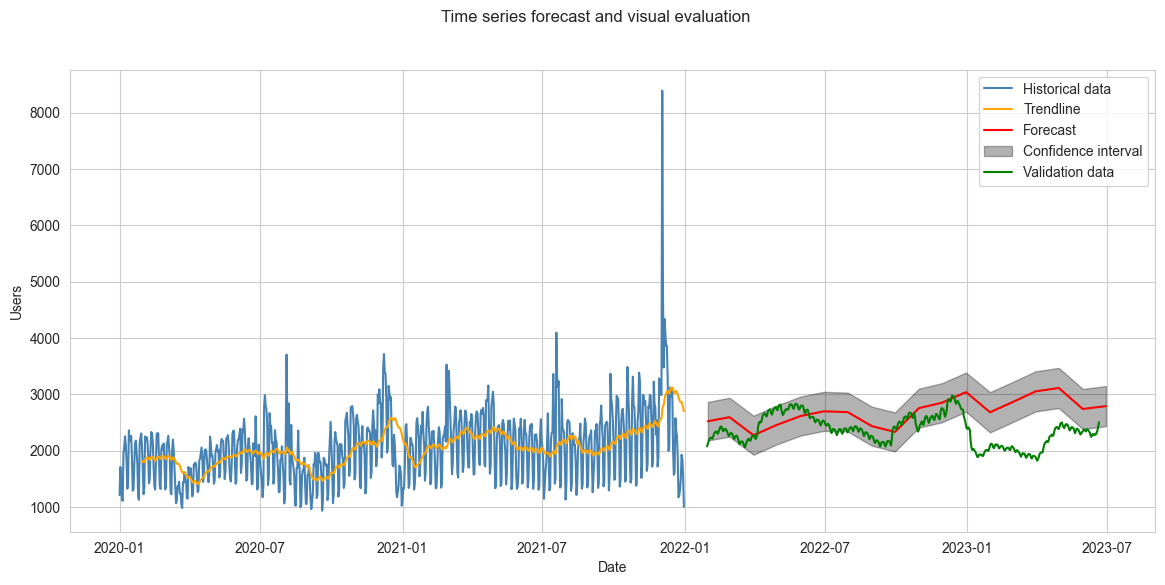

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81482D+00    |proj g|=  6.92356D-01

At iterate    5    f=  3.08631D+00    |proj g|=  9.24851D-03

At iterate   10    f=  3.08219D+00    |proj g|=  5.37500D-03

At iterate   15    f=  3.08108D+00    |proj g|=  2.39788D-03

At iterate   20    f=  3.08096D+00    |proj g|=  6.86220D-05

At iterate   25    f=  3.08093D+00    |proj g|=  2.74645D-04

At iterate   30    f=  3.07990D+00    |proj g|=  1.52653D-02

At iterate   35    f=  3.07827D+00    |proj g|=  6.02983D-03

At iterate   40    f=  3.07793D+00    |proj g|=  2.48260D-03


 This problem is unconstrained.



At iterate   45    f=  3.07769D+00    |proj g|=  4.65840D-03

At iterate   50    f=  3.07754D+00    |proj g|=  8.92208D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   8.922D-04   3.078D+00
  F =   3.0775429421037988     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


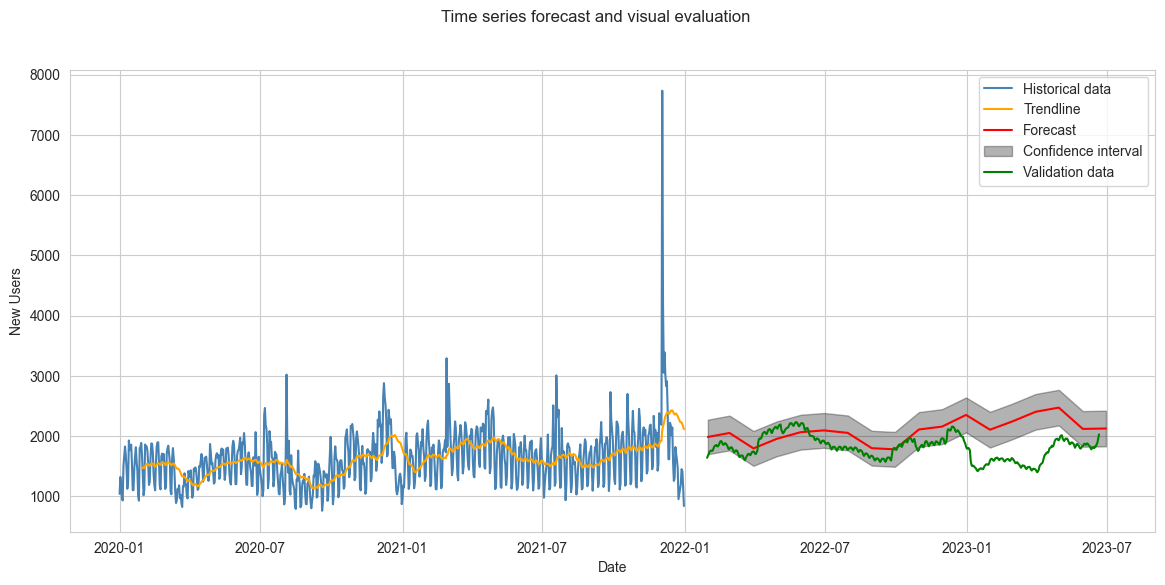

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85123D+00    |proj g|=  2.79757D-02

At iterate    5    f=  1.82427D+00    |proj g|=  4.15203D-02

At iterate   10    f=  1.81808D+00    |proj g|=  8.81662D-03

At iterate   15    f=  1.81726D+00    |proj g|=  3.46250D-03

At iterate   20    f=  1.81700D+00    |proj g|=  2.15622D-03

At iterate   25    f=  1.81687D+00    |proj g|=  1.39044D-03

At iterate   30    f=  1.81680D+00    |proj g|=  1.35918D-03

At iterate   35    f=  1.81676D+00    |proj g|=  1.21233D-03

At iterate   40    f=  1.81672D+00    |proj g|=  6.88146D-04

At iterate   45    f=  1.81669D+00    |proj g|=  2.29698D-03

At iterate   50    f=  1.81667D+00    |proj g|=  7.94557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

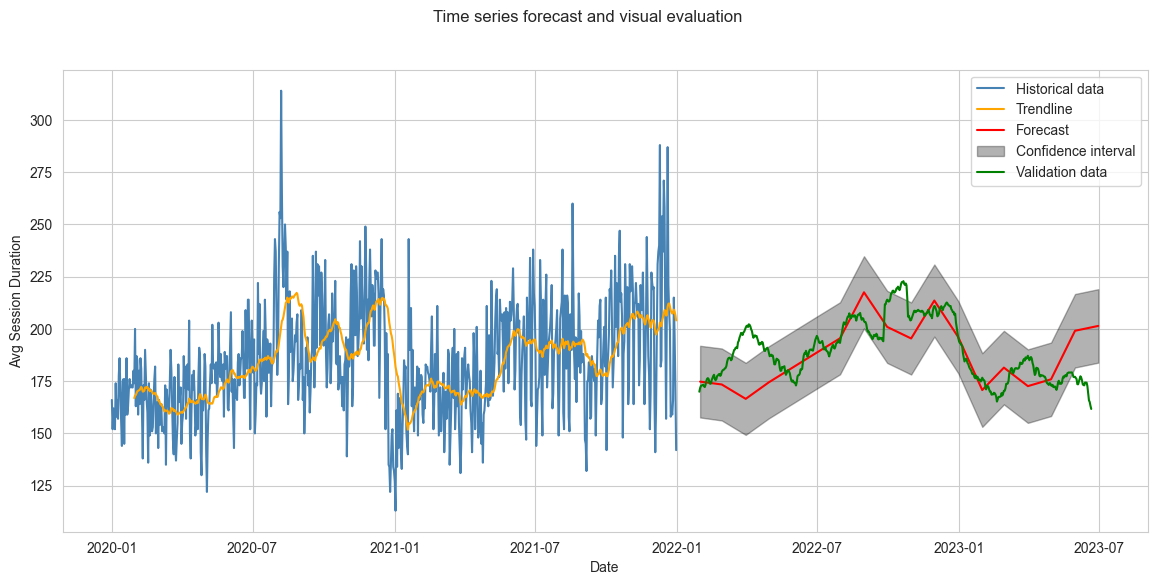

In [20]:
# Get forecast for every stationary time series

for c in stationary:
    make_prediction(c)